Import `qmprs` modules. For this demo, we will import the MPS instance.

In [1]:
from quick.circuit import QiskitCircuit
from quick.primitives import Ket

from qmprs.primitives import MPS
from qmprs.synthesis.mps_encoding import Sequential

/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


We will also import some basic modules for additional calculations and plotting.

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### State Preparation using MPS Sequential

This notebook is dedicated to the demonstration of how `qmprs` can be used to create and manipulate matrix product states (MPS). In this notebook, we will go over the main functionalities of the `MPS` class and how it can be used at the high level to perform conventional MPS operations. This will set the intuition for how MPS can be used in gate-based quantum computing applications to perform state preparation or unitary synthesis.

At a high level, MPS [[3]] can be understood as an approximation of a tensor network where we represent the approximation as the product of a series of matrices. This is useful for quantum computing where we represent quantum states as 1D tensors, and quantum operators as matrices operating on 1D tensors. We can use MPS to approximate a given quantum state (and similarly a Matrix Product Operator (MPO) to approximate a quantum operator) given some measure $\chi$ called the bond dimension, whereby increasing the bond dimension we can reach higher fidelity approximations but at the cost of larger matrices. Conventionally, the cost of an MPS is as follows:

Circuit depth = $O(dN\chi^2)$

Where $d$ is the physical dimension of the state (which is equal to 2 for qubit-based representation), and $N$ is the number of qubits required to represent the state. At a glance, one can infer that given a constant bond dimension the cost of preparing the state scales linearly with the number of qubits, which is an exponential reduction compared to the usual exact encoding schema seen in [[1]] and [[2]].

[1]: https://arxiv.org/abs/1501.06911
[2]: https://arxiv.org/abs/quant-ph/0406176
[3]: https://arxiv.org/pdf/quant-ph/0608197

Below is an example of how we can create an MPS for some arbitrary quantum state. For ease in assessing the fidelity of the MPS, we will use images and compare the original image with the extracted image after constructing the MPS, and calculate the fidelity of the two using a simple inner product. For this example, we will use a Fashion MNIST datapoint.

In [3]:
# Load in the resized MNIST dataset
dataset = pd.read_csv('datasets/mnist-resized.csv')

# Convert the dataset to a numpy array
images = dataset.to_numpy()[:,1:].reshape(30018, 8, 8)

# Get the first image
test_image = images.reshape(30018, 8, 8)[0, :]

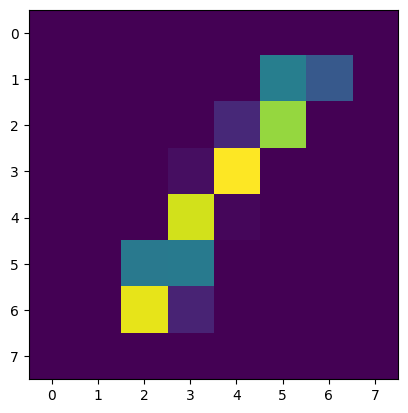

In [4]:
plt.imshow(test_image)

Next, we will convert this image to a quantum state using `quick.primitives.Ket`. `qmprs` is built with `quick` in mind, hence a great amount of the package utilizes the codebase built in `quick`.

In [5]:
# Create a `quick.primitives.Ket` instance
state = Ket(test_image.flatten())

# Create a `qmprs.mps.MPS` instance
mps = MPS(statevector=state, bond_dimension=8)

We can then reconstruct the state vector using `.to_statevector()` method.

/tmp/ipykernel_1464870/3231258830.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  state = MPS.to_statevector(mps.mps).data.astype(float)


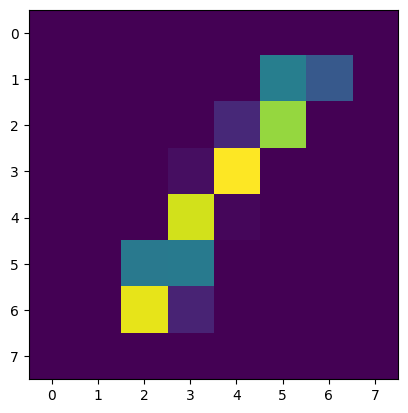

In [6]:
state = MPS.to_statevector(mps.mps).data.astype(float)

plt.imshow(state.reshape(8, 8))

MatrixProductState(tensors=6, indices=11, L=6, max_bond=5)

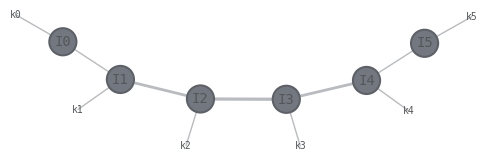

In [7]:
mps.draw()

mps.mps

In [8]:
sequential_encoder = Sequential(QiskitCircuit) 

In [9]:
circuit = sequential_encoder.prepare_mps(mps, num_layers=32)

Convert datatype to float for plotting purposes.

In [10]:
statevector = circuit.get_statevector().astype(float)

/tmp/ipykernel_1464870/3743751294.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  statevector = circuit.get_statevector().astype(float)


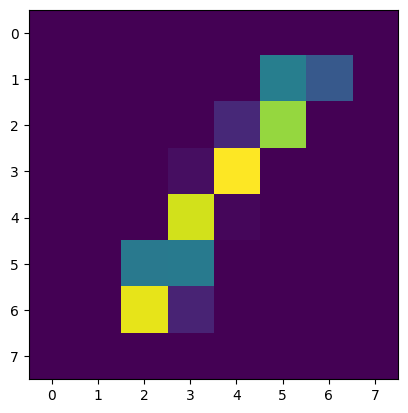

In [11]:
plt.imshow(statevector.reshape(8, 8))

In [12]:
np.dot(statevector, state)

array([0.99999902])

In [13]:
circuit.get_depth()

333

We can see the encoding working, but the depth is too large. Let's run the algorithm on a set of randomly generated states as we increase the number of qubits, and plot the depth and fidelity as they increase. This way we can get a better understanding of how the algorithm performs.

In [14]:
from quick.synthesis.statepreparation import Isometry

sequential = Sequential(QiskitCircuit)
isometry = Isometry(QiskitCircuit)

def generate_random_state(num_qubits: int) -> NDArray[np.complex128]:
    data = np.random.rand(2**num_qubits) + 1j * np.random.rand(2**num_qubits)
    data /= np.linalg.norm(data)
    return data

def generate_plot(num_qubits: int) -> tuple[list[int], list[int], list[int]]:
    isometry_depths = []
    sequential_depths = []
    sequential_fidelities = []

    for qubit in tqdm(range(2, num_qubits+1)):
        state = generate_random_state(qubit)

        circuit = isometry.prepare_state(state)
        depth = circuit.circuit.depth()
        isometry_depths.append(depth)

        mps = MPS(statevector=state, bond_dimension=2**qubit)
        if qubit < 6:
            circuit = sequential.prepare_mps(mps, num_layers=5)
        elif qubit < 10:
            circuit = sequential.prepare_mps(mps, num_layers=8)
        elif qubit < 14:
            circuit = sequential.prepare_mps(mps, num_layers=12)
        else:
            circuit = sequential.prepare_mps(mps, num_layers=16)
        depth = circuit.circuit.depth()
        sequential_depths.append(depth)
        print(circuit.count_ops())

        sequential_fidelities.append(np.dot(circuit.get_statevector().conj().T, state))

    return isometry_depths, sequential_depths, sequential_fidelities

isometry_depths, sequential_depths, sequential_fidelities = generate_plot(12)

 36%|███▋      | 4/11 [00:00<00:00, 25.74it/s]

{'U3': 9, 'GlobalPhase': 9, 'CX': 3}
{'U3': 17, 'GlobalPhase': 19, 'CX': 6}
{'U3': 100, 'GlobalPhase': 109, 'CX': 36}
{'U3': 165, 'GlobalPhase': 185, 'CX': 60}
{'U3': 328, 'GlobalPhase': 366, 'CX': 120}
{'U3': 392, 'GlobalPhase': 438, 'CX': 144}


 64%|██████▎   | 7/11 [00:00<00:00,  6.39it/s]

{'U3': 456, 'GlobalPhase': 509, 'CX': 168}
{'U3': 520, 'GlobalPhase': 582, 'CX': 192}


 82%|████████▏ | 9/11 [00:03<00:01,  1.90it/s]

{'U3': 876, 'GlobalPhase': 981, 'CX': 324}


 91%|█████████ | 10/11 [00:06<00:00,  1.02it/s]

{'U3': 972, 'GlobalPhase': 1088, 'CX': 360}


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]

{'U3': 1068, 'GlobalPhase': 1198, 'CX': 396}


[1.0, 1.0, 0.9999993576535, 0.9975922066534566, 0.9938175560524599, 0.9725820854477338, 0.9409295629375486, 0.9163069188922157, 0.908322349661459, 0.8900818276081197, 0.8766161835270044]
[8, 15, 64, 85, 134, 141, 148, 155, 218, 225, 232]
[8, 25, 70, 171, 384, 821, 1706, 3487, 7060, 14217, 28542]


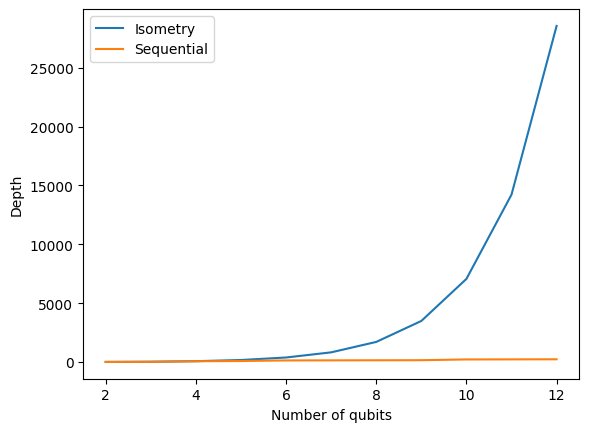

In [15]:
print([abs(x) for x in sequential_fidelities])
print(sequential_depths)
print(isometry_depths)

plt.plot(range(2, 13), isometry_depths, label="Isometry")
plt.plot(range(2, 13), sequential_depths, label="Sequential")

plt.xlabel("Number of qubits")
plt.ylabel("Depth")

plt.legend()
plt.show()

Let's generate a closer plot for sequential on its own.

In [16]:
isometry_depths, sequential_depths, sequential_fidelities = generate_plot(17)

  0%|          | 0/16 [00:00<?, ?it/s]

{'U3': 9, 'GlobalPhase': 10, 'CX': 3}
{'U3': 17, 'GlobalPhase': 19, 'CX': 6}
{'U3': 125, 'GlobalPhase': 136, 'CX': 45}


 25%|██▌       | 4/16 [00:00<00:00, 22.48it/s]

{'U3': 165, 'GlobalPhase': 184, 'CX': 60}
{'U3': 328, 'GlobalPhase': 366, 'CX': 120}
{'U3': 392, 'GlobalPhase': 438, 'CX': 144}


 44%|████▍     | 7/16 [00:00<00:01,  6.20it/s]

{'U3': 456, 'GlobalPhase': 510, 'CX': 168}
{'U3': 520, 'GlobalPhase': 583, 'CX': 192}


 56%|█████▋    | 9/16 [00:03<00:03,  1.76it/s]

{'U3': 876, 'GlobalPhase': 981, 'CX': 324}


 62%|██████▎   | 10/16 [00:06<00:06,  1.04s/it]

{'U3': 972, 'GlobalPhase': 1089, 'CX': 360}


 69%|██████▉   | 11/16 [00:14<00:12,  2.54s/it]

{'U3': 1068, 'GlobalPhase': 1196, 'CX': 396}


 75%|███████▌  | 12/16 [00:32<00:24,  6.09s/it]

{'U3': 1164, 'GlobalPhase': 1306, 'CX': 432}
{'U3': 1680, 'GlobalPhase': 1884, 'CX': 624}


 81%|████████▏ | 13/16 [01:14<00:45, 15.00s/it]

{'U3': 1808, 'GlobalPhase': 2028, 'CX': 672}


 88%|████████▊ | 14/16 [02:48<01:11, 35.84s/it]

{'U3': 1936, 'GlobalPhase': 2169, 'CX': 720}


 94%|█████████▍| 15/16 [05:44<01:14, 74.23s/it]

{'U3': 2064, 'GlobalPhase': 2314, 'CX': 768}


100%|██████████| 16/16 [16:14<00:00, 60.90s/it] 


In [24]:
# Fit a linear model to half of the data
linear_fit = np.polyfit(range(2, 13), sequential_depths[:11], 1)

# Predict the depth of the remaining data
linear_values = np.polyval(linear_fit, range(2, 18))
linear_values

array([ 15.63636364,  38.67272727,  61.70909091,  84.74545455,
       107.78181818, 130.81818182, 153.85454545, 176.89090909,
       199.92727273, 222.96363636, 246.        , 269.03636364,
       292.07272727, 315.10909091, 338.14545455, 361.18181818])

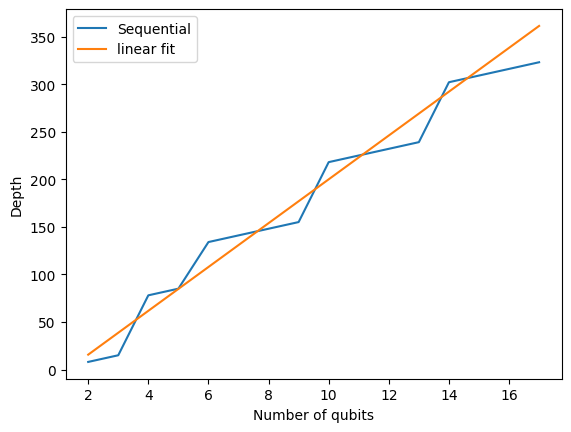

In [25]:
plt.plot(range(2, 18), sequential_depths, label="Sequential")
plt.plot(range(2, 18), linear_values, label="linear fit")
plt.xlabel("Number of qubits")
plt.ylabel("Depth")

plt.legend()
plt.show()

Wow, that's a rather drastic difference! Let's analyze the results a bit:
- Depth scaling: In the isometry approach, we see the depth approximately double as we add a qubit, which gives it its notorious exponential scaling of $O(2^N)$, whereas in Sequential encoding we linearly scale, giving it $O(N)$.
- Fidelity: As the number of qubits increases, we can see the approximation begins to slightly reduce. This is expected from vanilla Sequential as the algorithm does not scale significantly with increasing number of layers, thus why we have optimizations to improve the fidelity and indirectly depth scaling for a target fidelity.


So, as we see the Sequential approach indeed provides an exponential reduction in circuit depth scaling, however, we pay for this reduction with a slight hit to the fidelities. 'Tis the cost of approximation gentlefolk.

For those more curious, let's take the analysis further. Below, we can see the impact of the number of layers more closely.

In [26]:
layers = range(1, 100)
fidelities = []
depths = []

state = generate_random_state(8)
sequential_encoder = Sequential(QiskitCircuit)
mps = MPS(statevector=state, bond_dimension=8)

for layer in layers:
    circuit = sequential_encoder.prepare_mps(mps, num_layers=layer)
    statevector = circuit.get_statevector()
    fidelity = abs(np.dot(statevector.conj(), state))
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

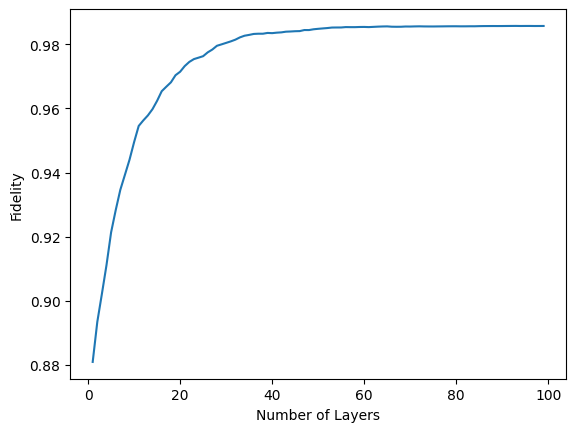

In [27]:
plt.plot(layers, fidelities)
plt.xlabel("Number of Layers")
plt.ylabel("Fidelity")
plt.show()

We can see the fidelity's growth slows and eventually stops after a certain number of layers. This is because given the approximation after a few layers the MPS cannot be disentangled further. Therefore the higher the bond dimension, the further we can push the max fidelity. Thus with a well-chosen bond dimension one can find the best number of layers given the point of plateau.

In [28]:
# Create a `quick.primitives.Ket` instance
state = Ket(test_image.flatten())

# Create a `qmprs.mps.MPS` instance
mps = MPS(statevector=state, bond_dimension=8)

In [29]:
layers = range(1, 100)
fidelities = []
depths = []

sequential_encoder = Sequential(QiskitCircuit)

for layer in layers:
    circuit = sequential_encoder.prepare_mps(mps, num_layers=layer)
    statevector = circuit.get_statevector()
    fidelity = abs(np.dot(statevector.conj(), state.data.flatten()))
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

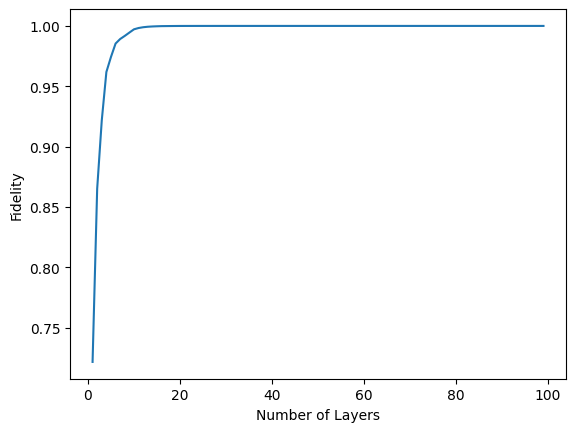

In [30]:
plt.plot(layers, fidelities)
plt.xlabel("Number of Layers")
plt.ylabel("Fidelity")
plt.show()

Here is an important matter to note. MPS was originally conceived to approximate *weakly* entangled states. Data such as images are of this category[[4]], and thus they are much easier to approximate, and reach target fidelity much much faster compared to randomly generated states. This is something that is expected and forms the pillar of why MPS is useful in the first place. With MPS representation we exploit the entanglement structure in a state, and thus data with weak entanglement will be much easier to encode and approximate.

[4]: https://arxiv.org/abs/2311.07666 

### Final thoughts

MPS is a natural tool for quantum computing given how quantum circuits are essentially tensor networks. By utilizing such structures, we can address bottlenecks such as state preparation, unitary preparation, and by extention any arbitrary quantum computing use-case. Same as all things, they have their downsides, such as the need for higher bond dimension and number of layers to represent arbitrary states as MPS.

Our focus with `qmprs` is to provide a compiler to provide a robust and stable performance for arbitrary states and operators, however, this is one challenge that is inherent to MPS as a whole.

<p>© 2025 Qualition Computing, all rights reserved.</p>